This notebook demonstrates filtering and reprojection of point cloud at a given viewpoint with camera metadata. Requires plotly package for points visualisation which can be installed through _pip install plotly_

In [11]:
import numpy as np
from PIL import Image, ImageDraw
import laspy
from matplotlib import pyplot as plt
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
from lidar.point_cloud_processings import remove_noise, get_rotation_matrix, project_lidar_perspective, project_lidar_equirectangular
import plotly.graph_objects as go

### Read LiDAR points from a .las file

In [12]:
las_file_path = r"C:\Users\lliu\Desktop\FrontierSI\projects\GA_floor_height\QA4lidar\2_clipped_buffered.las"
with laspy.open(las_file_path) as las:
    lidar_data = las.read()
    lidar_points = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).T  # Extract x, y, z coordinates


### Filter point cloud

In [13]:
# Remove noise points using DBSCAN
eps = 3  # Maximum distance between points to be considered neighbors (meters)
min_samples = 2  # Minimum number of points to form a cluster
lidar_points = remove_noise(lidar_points, eps, min_samples)
lidar_points

array([[7.25662140e+05, 7.66213392e+06, 1.02200000e+01],
       [7.25662650e+05, 7.66213256e+06, 8.65000000e+00],
       [7.25662560e+05, 7.66213255e+06, 8.77000000e+00],
       ...,
       [7.25659340e+05, 7.66214385e+06, 1.03200000e+01],
       [7.25659150e+05, 7.66214469e+06, 1.03500000e+01],
       [7.25659010e+05, 7.66214482e+06, 1.02900000e+01]])

### Set camera metadata
* coordinates including elevation
* viewing angles

In [14]:
# Camera in EPSG:4326 (longitude, latitude, height)
# camera_position = (149.1728570, -21.1282603, 10)  
camera_position = (149.1726996, -21.1281156, 10)  
# yaw = np.radians(0)         # Camera yaw angle
yaw = np.radians(90)         # Camera yaw angle
pitch = np.radians(0)        # Camera pitch angle
roll = np.radians(0)         # Camera roll angle
orientation=(yaw, pitch, roll)
# Image dimensions
image_width = 256
image_height = 256
resolution=(image_width,image_height)
# Field of views in degrees
fov_v=np.radians(90)
fov_h = np.radians(90)
# fill value for background pixels
nodata_value=-9999

### Reproject viewpoint to CRS of point cloud

In [15]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:28355", always_xy=True)
camera_easting, camera_northing = transformer.transform(camera_position[0], camera_position[1])
camera_position=(camera_easting, camera_northing,camera_position[2])
camera_position

(725653.1460448012, 7662130.643201064, 10)

### Visualise point cloud and viewpoint

In [16]:
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=lidar_points[:, 0],
    y=lidar_points[:, 1],
    z=lidar_points[:, 2],
    mode='markers',
    marker=dict(size=1, color='blue')),
    go.Scatter3d(
    x=[camera_position[0]],
    y=[camera_position[1]],
    z=[camera_position[2]],
    mode='markers',
    marker=dict(size=5, color='red'))])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Show the plot
fig.show()

### Project point cloud as an image
* perspective projection

In [17]:
# Project points
# elevation_image, depth_image = project_lidar_perspective(lidar_points, camera_position, orientation, resolution, fov_h,no_data_value=nodata_value)


* equirectangular projection

In [18]:
elevation_image, depth_image = project_lidar_equirectangular(lidar_points, camera_position, orientation, fov_h, fov_v,resolution,no_data_value=nodata_value)

number of points within view:  9949


### Visualise projected image

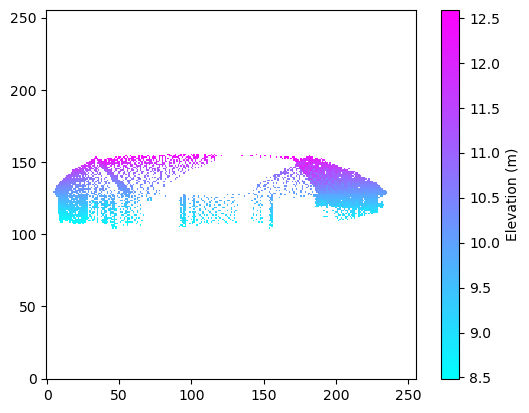

In [19]:
elevation_image_copy=elevation_image.copy()
elevation_image_copy[elevation_image_copy==nodata_value] = np.nan
plt.imshow(elevation_image_copy,cmap='cool',interpolation='none',origin='lower')
# plt.imshow(elevation_image_copy,cmap='cool',interpolation='none')
plt.colorbar(label='Elevation (m)')

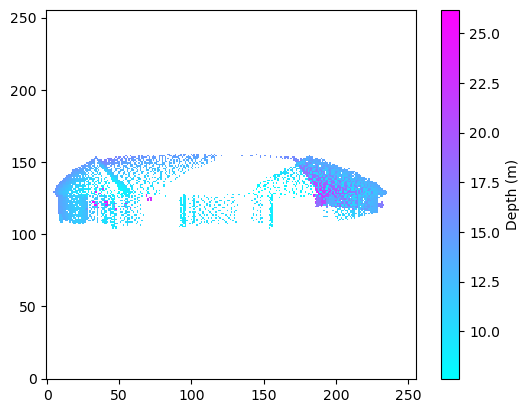

In [20]:
depth_image_copy=depth_image.copy()
depth_image_copy[depth_image_copy==nodata_value] = np.nan
plt.imshow(depth_image_copy,cmap='cool',interpolation='none',origin='lower')
plt.colorbar(label='Depth (m)')